# Keyness Analysis Per Theme

In [1]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [2]:
import ast
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

#### Set paths and load functions

In [3]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
raw_review_data = '../data/reviews-stats.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"
isbn_topic_file = '../data/isbn_topic_scores.tsv.gz'

## Read information on ISBN, Topic and Theme

In [4]:
isbn_topic = pd.read_csv(isbn_topic_file, sep='\t', compression='gzip', dtype={'isbn': str})

# Turn the theme string into a Python list object
isbn_topic['themes'] = isbn_topic.themes.apply(ast.literal_eval)

# explode the themes lists so that each theme is column and rows indicate 
# whether an ISBN has been assigned to a theme.
isbn_theme = isbn_topic.explode('themes')[['isbn', 'themes']].set_index('isbn')
isbn_theme = pd.get_dummies(isbn_theme).reset_index().groupby('isbn').sum().reset_index()
isbn_theme

,isbn,themes_Arts,themes_Behaviours / feelings,themes_Crime,themes_Culture,themes_Geography and setting,themes_History,themes_Law,themes_Lifestyle and sport,themes_Medicine / health,themes_Other,themes_Politics,"themes_Religion, spirituality and philosophy",themes_Romance and sex,themes_School,"themes_Supernatural, fantasy and sci-fi",themes_War,themes_Wildlife / nature
0,9789020200485,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9789020201451,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,9789020202106,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,9789020205008,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9789020205268,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18462,9789493189560,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
18463,9789493189584,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,9789493189607,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
18465,9789493189669,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Combine Work identifier and Genre to Topic and Theme information

In [8]:
from impfic_core.map.map_genre import read_genre_file

# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)
work_genre = work_genre[work_genre.record_id_type == 'isbn'].rename(columns={'record_id': 'isbn'})
work_genre = work_genre[['work_id', 'isbn', 'nur_genre']]
work_genre.shape

(189038, 3)

In [9]:
# merge and drop the ISBN column, since we need only the work_id to link
# topic and theme to the reviews and impact terms
work_genre_theme = pd.merge(work_genre, isbn_theme, on='isbn').drop('isbn', axis=1)

# the collection has 18,465 books, so there should be 18,465 rows
work_genre_theme.shape

(18465, 19)

In [10]:
# Some insight in the distribution of books over genres
work_genre_theme.nur_genre.value_counts() / len(work_genre_theme)

Literary_fiction      0.298890
Non-fiction           0.284538
Other fiction         0.108042
Suspense              0.092066
Regional_fiction      0.047983
Literary_thriller     0.044571
Children_fiction      0.030219
Romanticism           0.028703
Young_adult           0.026807
Fantasy_fiction       0.019767
Historical_fiction    0.018413
Name: nur_genre, dtype: float64

In [11]:

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

# merge review metadata and genre data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# review professional reviews
review_stats = review_stats[review_stats.source != 'NBD_Biblion']


In [12]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634614


Literary_fiction      0.298400
Non-fiction           0.148594
Literary_thriller     0.118297
Suspense              0.103085
Other fiction         0.053837
Young_adult           0.044741
Children_fiction      0.039093
Fantasy_fiction       0.019913
Romanticism           0.009792
Historical_fiction    0.005120
Regional_fiction      0.002164
Name: nur_genre, dtype: float64

Since themes can have overlap (the same topic assigned to multiple themes, leads to books of that topic to be assigned to multiple themes)

Number of books with multiple themes:

### Counting number of words per theme

- **target corpus size**: sum of number of words of reviews of works in theme
- **reference corpus size**: sum of number of words of reviews of works _not_ in theme



In [15]:
review_work_theme = pd.merge(review_stats, work_genre_theme, on='work_id', how='right')

print('number of reviews (with duplicates for works with multiple themes):', review_work_theme.shape)


number of reviews (with duplicates for works with multiple themes): (140511, 29)


In [16]:
# get a list of all the column names for the themes
theme_cols = [col for col in review_work_theme.columns if col.startswith('themes_')]

work_genre_theme[theme_cols].sum(axis=1).value_counts()

1    9208
2    9105
3      87
4      65
dtype: int64

Half of the books in the corpus have a single theme, the other half of the books have two themes. Only a handful have 3 or 4 themes.

In [17]:
# compute the size of the _target_ and _reference_ corpus 
targets = []
refs = []
for theme_col in theme_cols:
    target = review_work_theme[review_work_theme[theme_col] == 1].review_num_words.sum()
    ref = review_work_theme[review_work_theme[theme_col] == 0].review_num_words.sum()
    targets.append(target)
    refs.append(ref)

#
target_total = review_work_theme.review_num_words.sum()
ref = 0
targets.append(target_total)
refs.append(ref)

review_theme_totals = pd.DataFrame(data = {
    'theme': [col.replace('themes_', '') for col in theme_cols] + ['Total'], 
    'target_freq': targets, 
    'ref_freq': refs
}).set_index('theme')

review_theme_totals

,target_freq,ref_freq
theme,,
Arts,7430850.0,15254333.0
Behaviours / feelings,7015434.0,15669749.0
Crime,4567190.0,18117993.0
Culture,649254.0,22035929.0
Geography and setting,3269885.0,19410356.0
History,162567.0,22522616.0
Law,418288.0,22266895.0
Lifestyle and sport,25975.0,22659208.0
Medicine / health,791663.0,21893520.0


In [18]:
# Read the impact matches and select column to identify each instance of
# an impact term (review_id, sentence_index and match_index determine 
# which token(s) make up the impact term) for each impact type.

# Multiple rules can identify the same token(s) as expressing the same
# impact type, but we only want to count those token(s) once.
impact_matches = pd.read_csv(impact_file, sep='\t', compression='gzip')

print('total number of impact matches:', len(impact_matches))

impact_matches = impact_matches[['review_id', 'sentence_index', 'match_index', 'impact_type', 'impact_term']].drop_duplicates()
print('total number of distinct impact instances:', len(impact_matches))


# drop reflection impact matches, as reflection is not a validated impact type
impact_matches = impact_matches[impact_matches.impact_type != 'Reflection']

print('total number of distinct impact instances after dropping reflection matches:', len(impact_matches))


total number of impact matches: 2423804
total number of distinct impact instances: 2392079
total number of distinct impact instances after dropping reflection matches: 2110363


Now merge the impact matches with the work_id and review_id and then with the theme information.

In [19]:
# How many different impact terms are used across all reviews?
impact_matches.groupby('impact_type').impact_term.nunique()

impact_type
Affect       49
Narrative    85
Style        56
Name: impact_term, dtype: int64

In [22]:
work_review_impact = (pd.merge(review_stats[['work_id', 'review_id']], impact_matches, on='review_id', how='inner')
                      .drop(['sentence_index', 'match_index'], axis=1))

print('number of impact matches:', len(work_review_impact))

number of impact matches: 2058101


In [23]:
impact_theme = pd.merge(work_review_impact, 
                        work_genre_theme, 
                        on='work_id', 
                        how='inner')

print('number of impact matches:', len(impact_theme))

number of impact matches: 468046


### Compute Size of Target and Reference Corpora

In [24]:
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]
total_target = impact_theme.groupby('impact_type')[theme_cols].sum()
total_all = impact_theme.groupby('impact_type')[theme_cols].count()

total_ref = total_all - total_target
total_target.T

impact_type,Affect,Narrative,Style
themes_Arts,43331,46917,55916
themes_Behaviours / feelings,57119,52019,47197
themes_Crime,29293,41383,24484
themes_Culture,4388,5159,3917
themes_Geography and setting,19297,20769,22982
themes_History,915,1295,1069
themes_Law,2414,3145,2542
themes_Lifestyle and sport,235,135,129
themes_Medicine / health,6458,2855,4789
themes_Other,250,220,254


Because an individual book can be assigned to multiple themes, the reviews of that books are also each linked to multiple themes, and the impact expressions as well.

To count the number of impact matches per theme, we transform the wide-format table to a long-format table with one line per impact term, per theme.

In [25]:
# select the column names of the themes
theme_cols = [col for col in impact_theme.columns if col.startswith('themes_')]

# transform impact_theme from wide to long format
impact_theme_long = impact_theme.melt(id_vars=['impact_type', 'impact_term'], 
                                      value_vars=theme_cols, value_name='has_theme', 
                                      var_name='theme')

print('number of impact matches after melt:', len(impact_theme_long))

impact_theme_long.head(5)

number of impact matches after melt: 7956782


,impact_type,impact_term,theme,has_theme
0,Affect,leuk,themes_Arts,1
1,Affect,aardig,themes_Arts,1
2,Style,mooi,themes_Arts,1
3,Narrative,fijn,themes_Arts,1
4,Style,mooi,themes_Arts,1


In [26]:
# the values in the theme_cols have zeros and ones indicating whether a
# the impact term (row) is assigned to each theme. 
impact_theme_long.groupby(['impact_type', 'theme']).has_theme.value_counts().rename('freq').reset_index()

,impact_type,theme,has_theme,freq
0,Affect,themes_Arts,0,109678
1,Affect,themes_Arts,1,43331
2,Affect,themes_Behaviours / feelings,0,95890
3,Affect,themes_Behaviours / feelings,1,57119
4,Affect,themes_Crime,0,123716
...,...,...,...,...
100,Style,"themes_Supernatural, fantasy and sci-fi",1,1778
101,Style,themes_War,0,122770
102,Style,themes_War,1,28531
103,Style,themes_Wildlife / nature,0,150834


In [27]:
# We're not interested in the cases where an impact term is not assigned to a theme.
# Therefore, we remove rows where has_theme is zero.
impact_theme_long = impact_theme_long[impact_theme_long.has_theme == 1].drop('has_theme', axis=1)
print('number of impact matches after removing non-theme rows:', len(impact_theme_long))

# remove the 'themes_' prefix from the theme names
impact_theme_long['theme'] = impact_theme_long.theme.apply(lambda theme: theme.replace('themes_', ''))
impact_theme_long.head(5)

number of impact matches after removing non-theme rows: 759741


,impact_type,impact_term,theme
0,Affect,leuk,Arts
1,Affect,aardig,Arts
2,Style,mooi,Arts
3,Narrative,fijn,Arts
4,Style,mooi,Arts


In [28]:
impact_types = list(impact_theme.impact_type.unique())
themes = list(impact_theme_long.theme.unique())
impact_types

['Affect', 'Style', 'Narrative']

Now we can compute the frequency of each impact term per theme and impact type:

In [29]:
key_cat_freq = (impact_theme_long.groupby(['impact_term', 'impact_type'])
                .theme.value_counts()
                .unstack()
                .fillna(0)
                .reset_index())

key_cat_freq['Total'] = key_cat_freq[themes].sum(axis=1)
key_cat_freq = key_cat_freq.set_index(['impact_type', 'impact_term'])
key_cat_freq.head(5)

theme                                                             Arts  \
impact_type impact_term                                                  
Narrative   (ik|je) (hoopte|hoopt)                                80.0   
            (ik|je|lezer) (voelt|voelde)                         712.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...  1306.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...   220.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                248.0   

theme                                                           Behaviours / feelings  \
impact_type impact_term                                                                 
Narrative   (ik|je) (hoopte|hoopt)                                              140.0   
            (ik|je|lezer) (voelt|voelde)                                        823.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...                 1708.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...                  222.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                               190.0   

theme                                                           Crime  \
impact_type impact_term                                                 
Narrative   (ik|je) (hoopte|hoopt)                               58.0   
            (ik|je|lezer) (voelt|voelde)                        390.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...  944.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...  158.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)               108.0   

theme                                                           Culture  \
impact_type impact_term                                                   
Narrative   (ik|je) (hoopte|hoopt)                                  9.0   
            (ik|je|lezer) (voelt|voelde)                           43.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...    111.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...     13.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                  15.0   

theme                                                           Geography and setting  \
impact_type impact_term                                                                 
Narrative   (ik|je) (hoopte|hoopt)                                               42.0   
            (ik|je|lezer) (voelt|voelde)                                        326.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...                  515.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...                   85.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                               100.0   

theme                                                           History  \
impact_type impact_term                                                   
Narrative   (ik|je) (hoopte|hoopt)                                  3.0   
            (ik|je|lezer) (voelt|voelde)                           11.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...     19.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...      7.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                   8.0   

theme                                                             Law  \
impact_type impact_term                                                 
Narrative   (ik|je) (hoopte|hoopt)                               11.0   
            (ik|je|lezer) (voelt|voelde)                         46.0   
            (in).+(één|een|1).+(adem|avond|dag|keer|middag|...  107.0   
            (laat|liet|lieten).+(mij|me|je|lezer).+(niet).+...   12.0   
            (neem*|nam).+(je|me|lezer|ons).+(mee)                13.0   

theme                                                           Lifestyle and sport  \
impact_type impact_term                                               

## Computing Keyness of Impact Terms per Theme and Impact Type

In [30]:
impact_type = 'Affect'
theme = 'Arts'
from src.keyness import compute_keyness

keyness = {}

for impact_type in impact_types:
    impact_keyness = pd.DataFrame()
    for theme in themes:
        impact_keyness[theme] = compute_keyness(key_cat_freq.loc[impact_type], 
                                                review_theme_totals, 
                                                theme)
    impact_keyness['impact_type'] = impact_type
    keyness[impact_type] = impact_keyness

keyness = pd.concat(keyness.values())
keyness[keyness.impact_type == 'Narrative']

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),95.873503,8.143276,36.768006,3.529171,24.240910,0.250350,0.068953,1.262551,8.661602,1.682393,10.958197,1.596837,0.537436,3.335833,12.902719,38.921742,5.523648,Narrative
(ik|je|lezer) (voelt|voelde),326.325444,132.054144,239.574842,48.379141,103.462641,11.497198,7.971404,3.538161,33.813146,0.066837,57.376776,12.095044,3.582814,84.209847,31.782348,239.604997,16.578056,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),937.718259,270.035017,315.502459,65.256720,434.448518,31.092799,8.696153,0.944531,41.414030,0.013994,24.125340,23.744559,26.441111,190.458369,61.638163,410.988641,6.938157,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),98.906200,72.932527,28.874924,15.290187,51.195293,0.155186,4.483804,2.587002,64.147900,0.042624,15.607929,0.640671,4.656147,40.913303,18.983574,25.437740,3.151122,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),30.627004,73.530286,63.080821,8.104646,17.621629,0.090828,1.842719,2.295987,0.116858,3.059482,3.007618,0.285184,4.132370,82.161707,15.452277,67.619421,4.813028,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,445.078287,202.361965,10.609356,4.668731,142.114649,17.583729,0.000631,1.847294,95.467265,8.085631,8.246771,20.119679,10.921071,118.618587,1.260964,56.044258,0.004378,Narrative
verrast,2.232144,0.739960,0.449613,0.058075,0.311375,0.014384,0.037222,0.002291,0.071043,0.003053,0.019888,0.010330,0.004124,0.624215,0.035335,0.510370,0.010025,Narrative
verslavend,44.717076,20.591079,8.677921,1.766429,45.888793,0.002189,2.420328,0.985291,5.490051,1.312935,3.638130,4.442060,25.661079,14.097215,0.340082,22.586146,4.310640,Narrative


## Computing Percent Difference of Impact Terms per Theme and Impact Type

In [31]:
from src.keyness import compute_percent_diff

percent_diff = {}

for impact_type in impact_types:
    impact_percent_diff = compute_percent_diff(key_cat_freq.loc[impact_type], review_theme_totals)
    impact_percent_diff['impact_type'] = impact_type
    percent_diff[impact_type] = impact_percent_diff

percent_diff = pd.concat(percent_diff.values())#.drop('Total', axis=1)
percent_diff[percent_diff.impact_type == 'Narrative']

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature,impact_type
impact_term,,,,,,,,,,,,,,,,,,
(ik|je) (hoopte|hoopt),-65.132259,-23.915935,-53.329540,-43.641432,-51.018449,-24.154968,8.438420,-100.000000,-59.255837,-100.000000,-100.000000,-64.889795,76.489117,-16.547646,-89.799669,-52.380557,-100.000000,Narrative
(ik|je|lezer) (voelt|voelde),-50.604230,-35.454295,-52.845908,-59.772976,-42.147451,-58.361216,-32.448643,-76.230333,-47.023822,-10.730026,-94.545323,-68.386446,-60.376557,-30.490641,-61.531938,-50.719807,-78.291937,Narrative
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),-57.410536,-35.262053,-43.745866,-49.701169,-56.857322,-65.281875,-23.992868,-31.085177,-37.113670,3.496237,-51.051777,-66.916452,156.295530,-31.705306,-59.858244,-46.924658,-39.598847,Narrative
(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los),-50.316346,-45.329483,-35.449611,-60.463712,-51.669705,-13.564604,-42.811023,-100.000000,-95.092263,16.153940,-91.128897,-31.340044,-100.000000,-37.251824,-80.052686,-32.149020,-64.683466,Narrative
(neem*|nam).+(je|me|lezer|ons).+(mee),-32.479591,-47.735708,-52.076642,-48.418872,-34.189607,11.503896,-30.026868,-100.000000,-5.818542,-100.000000,-49.816428,-22.602755,-100.000000,-52.313158,-77.514300,-51.417256,-80.119014,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
verrassing,-64.330116,-48.519008,-15.058051,-23.994511,-55.412991,-79.040304,0.363097,-67.043944,-82.130874,-100.000000,-50.631554,-92.704718,-100.000000,-40.783268,-16.137562,-31.262912,-1.817356,Narrative
verrast,inf,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,Narrative
verslavend,-53.796518,-40.041717,-31.901822,-35.658043,-72.558187,-2.662582,-50.015581,-100.000000,-54.235058,-100.000000,-76.674582,-100.000000,935.668319,-35.672609,-20.610631,-46.366032,-100.000000,Narrative


In [32]:
# the log-likelihood ratio threshold corresponding to a p-value of p<0.01
LL_threshold = 6.63

selected_diff_freq = pd.DataFrame()
df_list = []

for impact_type in impact_types:
    selected_diff = {}
    selected_freq = {}
    impact_selected_diff_freq = {}
    theme_df_list = []
    impact_keyness = keyness[keyness.impact_type == impact_type]
    impact_percent_diff = percent_diff[percent_diff.impact_type == impact_type]
    for theme in themes:
        key_impact_terms = impact_keyness[theme][impact_keyness[theme] > LL_threshold].index
        
        selected_diff[theme] = impact_percent_diff[theme].loc[key_impact_terms].rename('%Diff')
        
        selected_freq[theme] = key_cat_freq.loc[impact_type][theme][key_impact_terms].rename('Freq')
        theme_selected_diff_freq = pd.concat([selected_diff[theme], selected_freq[theme]], axis=1).reset_index()
        
        # add column with genre label
        theme_selected_diff_freq['theme'] = theme
        theme_df_list.append(theme_selected_diff_freq)
    impact_selected_diff_freq = pd.concat(theme_df_list)
    impact_selected_diff_freq['impact_type'] = impact_type
    df_list.append(impact_selected_diff_freq)

significant_diff_freq = pd.concat(df_list)
        
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-43.841209,563.0,Arts,Affect
1,aangenaam,-50.207248,839.0,Arts,Affect
2,aanraden,-54.211487,569.0,Arts,Affect
3,aanrader,-56.907515,3751.0,Arts,Affect
4,aardig,-45.571324,937.0,Arts,Affect
...,...,...,...,...,...
23,verbeelding,-100.000000,0.0,Wildlife / nature,Narrative
24,verdriet,-75.833799,2.0,Wildlife / nature,Narrative
25,verrassen,-35.530328,35.0,Wildlife / nature,Narrative
26,voelbaar,-100.000000,0.0,Wildlife / nature,Narrative


In [33]:
significant_diff_freq.shape, significant_diff_freq.replace([np.inf, -np.inf], np.nan).dropna().shape
significant_diff_freq['sign'] = significant_diff_freq['%Diff'].apply(lambda x: 'positive %Diff' if x > 0 else 'negative %Diff')
significant_diff_freq

,impact_term,%Diff,Freq,theme,impact_type,sign
0,(raakt|raken|raakte|raakten).+(me|mij|je|lezer),-43.841209,563.0,Arts,Affect,negative %Diff
1,aangenaam,-50.207248,839.0,Arts,Affect,negative %Diff
2,aanraden,-54.211487,569.0,Arts,Affect,negative %Diff
3,aanrader,-56.907515,3751.0,Arts,Affect,negative %Diff
4,aardig,-45.571324,937.0,Arts,Affect,negative %Diff
...,...,...,...,...,...,...
23,verbeelding,-100.000000,0.0,Wildlife / nature,Narrative,negative %Diff
24,verdriet,-75.833799,2.0,Wildlife / nature,Narrative,negative %Diff
25,verrassen,-35.530328,35.0,Wildlife / nature,Narrative,negative %Diff
26,voelbaar,-100.000000,0.0,Wildlife / nature,Narrative,negative %Diff


In [34]:
significant_diff_freq.groupby(['theme', 'impact_type'])
df_list = []

for impact_type in impact_types:
    for theme in themes:
        sdf = significant_diff_freq[(significant_diff_freq.impact_type == impact_type) & (significant_diff_freq.theme == theme)]
        top_sdf = pd.concat([
            sdf.sort_values('%Diff').tail(10), 
            sdf.sort_values('%Diff').head(10)
        ])
        df_list.append(top_sdf)

top_sdf = pd.concat(df_list)

In [35]:
sdf = significant_diff_freq
sdf.shape, top_sdf.shape

((1886, 6), (1008, 6))

In [36]:
# Number of impact terms per impact type
num_impact_terms = {
    'Affect': 149,
    'Narrative': 85,
    'Style': 56
}
num_terms_theme = sdf.groupby(['impact_type', 'theme', 'sign']).sign.count().unstack().fillna(0.0)
num_terms_theme

sign                                               negative %Diff  \
impact_type theme                                                   
Affect      Arts                                             43.0   
            Behaviours / feelings                            42.0   
            Crime                                            43.0   
            Culture                                          29.0   
            Geography and setting                            39.0   
            History                                          20.0   
            Law                                              31.0   
            Lifestyle and sport                               6.0   
            Medicine / health                                28.0   
            Other                                             8.0   
            Politics                                         27.0   
            Religion, spirituality and philosophy            28.0   
            Romance and sex                                   6.0   
            School                                           42.0   
            Supernatural, fantasy and sci-fi                 25.0   
            War                                              42.0   
            Wildlife / nature                                22.0   
Narrative   Arts                                             78.0   
            Behaviours / feelings                            73.0   
            Crime                                            72.0   
            Culture                                          55.0   
            Geography and setting                            71.0   
            History                                          27.0   
            Law                                              47.0   
            Lifestyle and sport                              11.0   
            Medicine / health                                67.0   
            Other                                            13.0   
            Politics                                         49.0   
            Religion, spirituality and philosophy            47.0   
            Romance and sex                                  20.0   
            School                                           71.0   
            Supernatural, fantasy and sci-fi                 47.0   
            War                                              75.0   
            Wildlife / nature                                28.0   
Style       Arts                                             39.0   
            Behaviours / feelings                            50.0   
            Crime                                            51.0   
            Culture                                          26.0   
            Geography and setting                            41.0   
            History                                          13.0   
            Law                                              25.0   
            Lifestyle and sport                               7.0   
            Medicine / health                                37.0   
            Other                                             7.0   
            Politics                                         25.0   
            Religion, spirituality and philosophy            16.0   
            Romance and sex                                  13.0   
            School                                           50.0   
            Supernatural, fantasy and sci-fi                 32.0   
            War                                              52.0   
            Wildlife / nature                                19.0   

sign                                               positive %Diff  
impact_type theme                                                  
Affect      Arts                                              0.0  
            Behaviours / feelings                             0.0  
            Crime                                             0.0  
  

In [37]:
theme_map_short = {
    "Arts": "Arts",
    "Behaviours / feelings": "Behav./feel.",
    "Crime": "Crime",
    "Culture": "Culture",
    "Geography and setting": "Geo./setting",
    "History": "History",
    "Law": "Law",
    "Lifestyle and sport": "Lifes./sport",
    "Medicine / health": "Med./health",
    "Other": "Other",
    "Politics": "Politics",
    "Religion, spirituality and philosophy": "Reli./spirit./phil.",
    "Romance and sex": "Romance/sex",
    "School": "School",
    "Supernatural, fantasy and sci-fi": "Super./fant./sci-fi",
    "War": "War",
    "Wildlife / nature": "Wildlife/nature"
}

#impact_terms_frac.rename(index=theme_map_short)

### Plotting the fraction of _key_ impact terms per genre


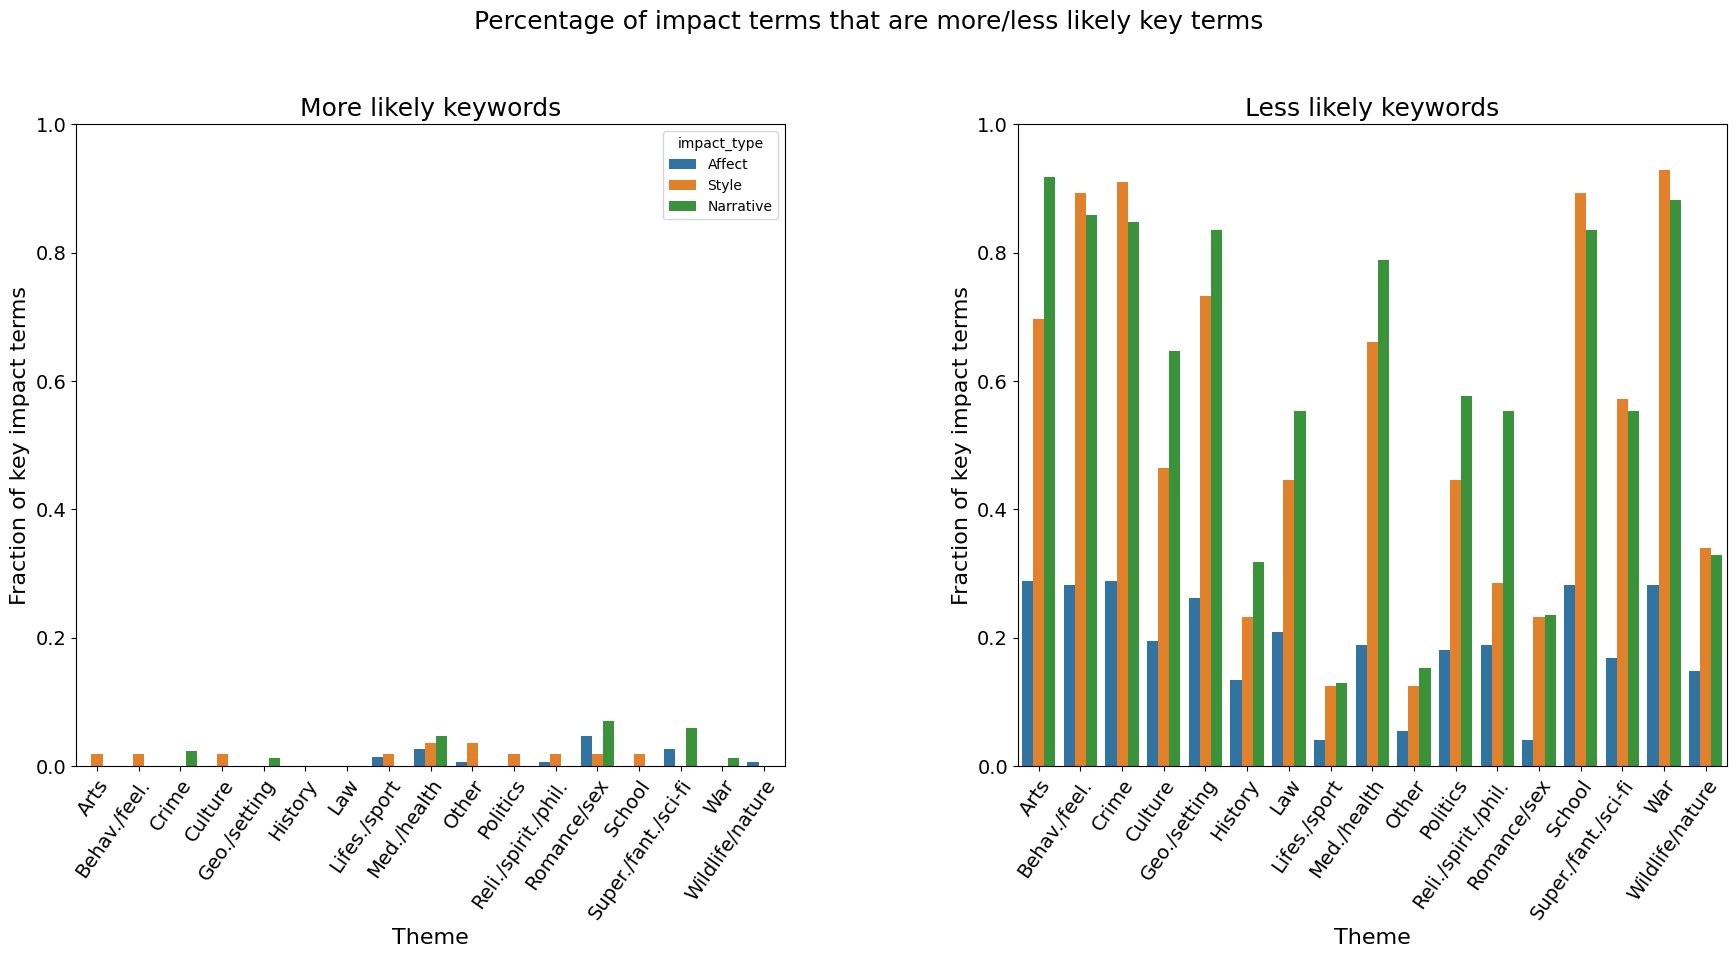

In [39]:
df_list = []
for impact_type in impact_types:
    impact_terms_frac = num_terms_theme.loc[impact_type] / num_impact_terms[impact_type]
    impact_terms_frac['impact_type'] = impact_type
    df_list.append(impact_terms_frac)

impact_terms_frac = pd.concat(df_list)


fig, ax = plt.subplots(1, 2)
sns.barplot(data=impact_terms_frac.rename(index=theme_map_short).reset_index(), x='theme', y='positive %Diff', hue='impact_type', ax=ax[0])
sns.barplot(data=impact_terms_frac.rename(index=theme_map_short).reset_index(), x='theme', y='negative %Diff', hue='impact_type', ax=ax[1])

ax[0].set_title('More likely keywords', fontsize=18)
ax[1].set_title('Less likely keywords', fontsize=18)

ax[0].set_xlabel('Theme', fontsize=16)
ax[1].set_xlabel('Theme', fontsize=16)
ax[0].set_ylabel('Fraction of key impact terms', fontsize=16)
ax[1].set_ylabel('Fraction of key impact terms', fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

# rotates labels and aligns them horizontally to left
# source: https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=55, ha="right", rotation_mode="anchor") 

ax[0].set_ylim(0, 1.0)
ax[1].set_ylim(0, 1.0)

fig.suptitle('Percentage of impact terms that are more/less likely key terms', fontsize=18)

ax[1].get_legend().remove()
#ax[1].legend(bbox_to_anchor=(1, 1))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)

fig.set_size_inches(18, 10)
plt.tight_layout(w_pad=12, pad=3)

fig.savefig('../images/num_key_terms_per_theme.png', dpi=150)

### Plot correlations of %Diff scores between themes

Each impact term has a %Diff score for each theme. Some themes might have similar %Diff scores for the same impact terms. A Pearson correlation ($\rho$) score is a crude measure, but it gives an indication of the similarity or difference between two pairs of themes. 

In [325]:
# Use the dataframe_image package to save correlation tables as images
import dataframe_image as dfi

In [326]:
(percent_diff[percent_diff.impact_type == 'Style']
 #.rename(columns=theme_map_short)
 #.drop(['Non-fic', 'Oth. fic'], axis=1)
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None))

,Arts,Behaviours / feelings,Crime,Culture,Geography and setting,History,Law,Lifestyle and sport,Medicine / health,Other,Politics,"Religion, spirituality and philosophy",Romance and sex,School,"Supernatural, fantasy and sci-fi",War,Wildlife / nature
Arts,1.00,-0.67,-0.02,-0.04,0.51,0.10,0.40,-0.23,-0.32,-0.11,-0.10,0.16,-0.27,-0.67,-0.50,0.06,0.07
Behaviours / feelings,-0.67,1.00,-0.43,-0.00,-0.35,-0.38,-0.43,0.46,0.45,-0.03,-0.05,-0.02,0.28,0.96,0.39,-0.46,0.00
Crime,-0.02,-0.43,1.00,0.31,0.27,0.51,0.45,-0.30,-0.24,0.18,0.22,-0.01,-0.08,-0.38,0.02,0.92,0.09
Culture,-0.04,-0.00,0.31,1.00,-0.10,0.03,0.10,0.08,0.04,0.07,0.05,0.48,0.22,-0.02,0.14,0.07,0.60
Geography and setting,0.51,-0.35,0.27,-0.10,1.00,0.41,0.52,-0.19,-0.30,0.01,0.08,-0.30,-0.18,-0.32,-0.29,0.42,-0.32
History,0.10,-0.38,0.51,0.03,0.41,1.00,0.28,-0.11,-0.27,0.22,0.19,-0.18,-0.23,-0.34,-0.17,0.54,0.02
Law,0.40,-0.43,0.45,0.10,0.52,0.28,1.00,-0.27,-0.24,-0.06,0.13,-0.21,-0.04,-0.41,-0.26,0.40,-0.06
Lifestyle and sport,-0.23,0.46,-0.30,0.08,-0.19,-0.11,-0.27,1.00,0.14,0.04,-0.07,-0.06,0.17,0.44,0.11,-0.30,0.02
Medicine / health,-0.32,0.45,-0.24,0.04,-0.30,-0.27,-0.24,0.14,1.00,-0.02,0.36,0.34,0.13,0.21,0.16,-0.28,0.10
Other,-0.11,-0.03,0.18,0.07,0.01,0.22,-0.06,0.04,-0.02,1.00,-0.04,-0.15,-0.16,-0.01,0.26,0.15,-0.12


In [327]:
# Correlations between genres for affective impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Affect']
 .drop('impact_type', axis=1)
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-affect.png', dpi=150)

In [328]:
# Correlations between genres for narrative impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Narrative']
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-narrative.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73139/962286834.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()


In [329]:
# Correlations between genres for stylistic impact terms
dfi.export(percent_diff[percent_diff.impact_type == 'Style']
 .corr()
 .style.format(precision=2)
 .background_gradient(axis=None), '../images/percent_diff_corr/percent_diff_corr-theme-style.png', dpi=150)

/var/folders/xk/pp9n20396sqccydf42gn2rmr0000gn/T/ipykernel_73139/2241219179.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .corr()
